In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import plot_partial_dependence
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, PolynomialFeatures
# import xgboost as xgb
from datetime import datetime
import seaborn as sns

In [3]:
data_train = pd.read_csv('./Bike_train.csv')
data_test = pd.read_csv('./Bike_test.csv')
data_train

,daylabel,year,month,day,hour,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,1,2011,1,1,0,1,0,0,1.0,9.84,14.395,81.0,0.0000,16
1,1,2011,1,1,1,1,0,0,1.0,9.02,13.635,80.0,0.0000,40
2,1,2011,1,1,2,1,0,0,1.0,9.02,13.635,80.0,0.0000,32
3,1,2011,1,1,3,1,0,0,1.0,9.84,14.395,75.0,0.0000,13
4,1,2011,1,1,4,1,0,0,1.0,9.84,14.395,75.0,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10927,719,2012,12,19,19,4,0,1,1.0,15.58,19.695,50.0,26.0027,336
10928,719,2012,12,19,20,4,0,1,1.0,14.76,17.425,57.0,15.0013,241
10929,719,2012,12,19,21,4,0,1,1.0,13.94,15.910,61.0,15.0013,168
10930,719,2012,12,19,22,4,0,1,1.0,13.94,17.425,61.0,6.0032,129


### 1. Data Exploring
#### a. Visualize the relationship between count and windspeed, humidity, temp, and atemp on a separate scatter plot.

Text(0.5, 0, 'Atemp')

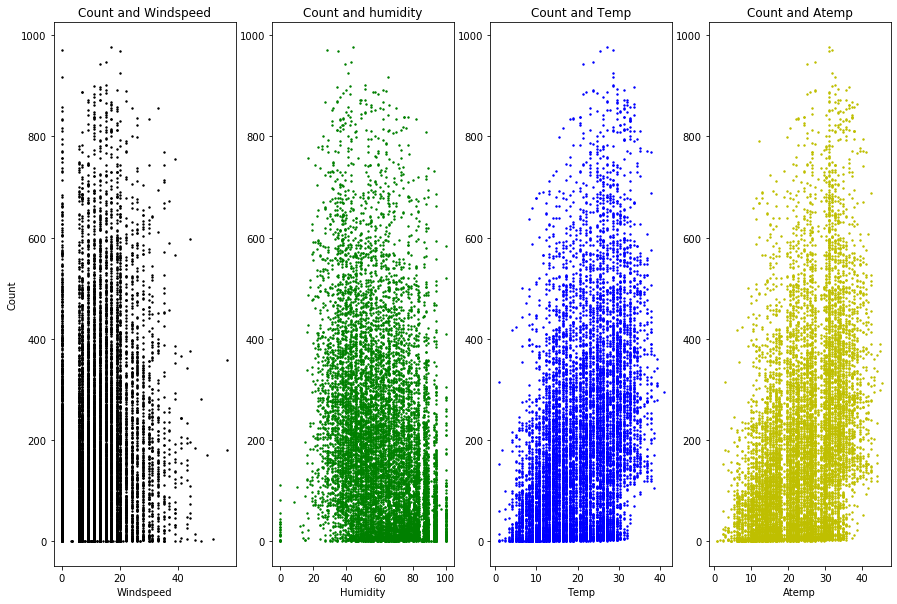

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(1, 4, 1)
plt.scatter(data_train['windspeed'], data_train['count'], s=2, color='k')
plt.title("Count and Windspeed")
plt.xlabel('Windspeed')
plt.ylabel('Count')
plt.subplot(1, 4, 2)
plt.scatter(data_train['humidity'], data_train['count'], s=2, color='g')
plt.title("Count and humidity")
plt.xlabel('Humidity')
plt.subplot(1, 4, 3)
plt.scatter(data_train['temp'], data_train['count'], s=2, color='b')
plt.title("Count and Temp")
plt.xlabel('Temp')
plt.subplot(1, 4, 4)
plt.scatter(data_train['atemp'], data_train['count'], s=2, color='y')
plt.title("Count and Atemp")
plt.xlabel('Atemp')

#### b. Visualize the relationship with count depend on the season with a boxplot.

/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Relationship with Count Depending on the Season')

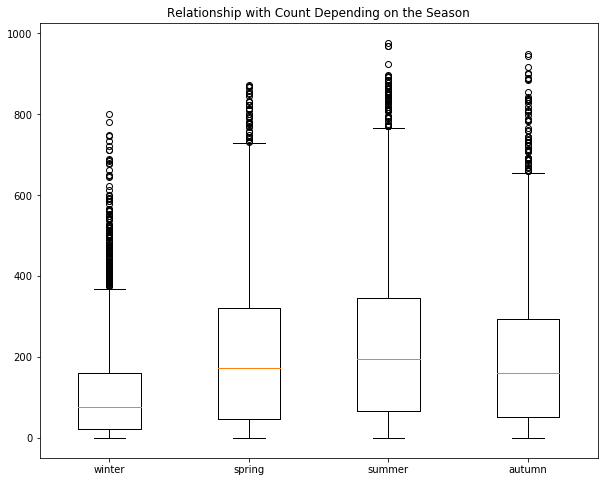

In [14]:
winter = data_train[data_train['season'] == 1]['count']
spring = data_train[data_train['season'] == 2]['count']
summer = data_train[data_train['season'] == 3]['count']
autumn = data_train[data_train['season'] == 4]['count']
plt.figure(figsize=(10, 8))
labels = 'winter', 'spring', 'summer', 'autumn'
plt.boxplot([winter, spring, summer, autumn], labels=labels)
plt.title('Relationship with Count Depending on the Season')

#### c. How does count depend on the time of the day (hour)? Color the observations on the scatterplot using the temperature.

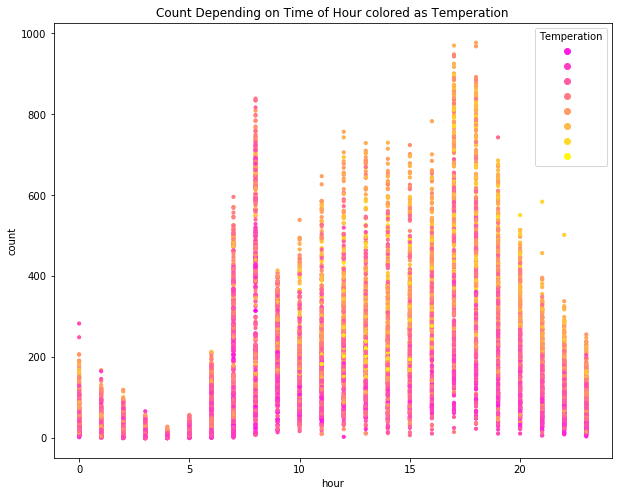

In [15]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_train['hour'], data_train['count'], c=data_train['temp'], cmap='spring', s=10)
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Count Depending on Time of Hour colored as Temperation')
plt.legend(handles=scatter.legend_elements()[0], title="Temperation")

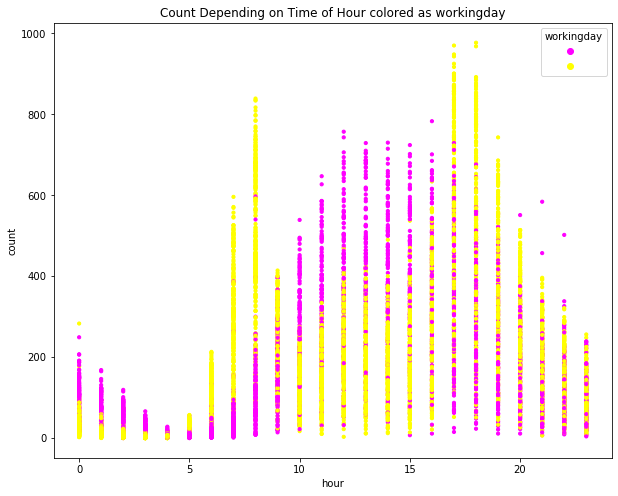

In [16]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_train['hour'], data_train['count'], c=data_train['workingday'], cmap='spring', s=10)
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Count Depending on Time of Hour colored as workingday')
plt.legend(handles=scatter.legend_elements()[0], title="workingday")

#### d. Does the relationship between count and hour change by season?

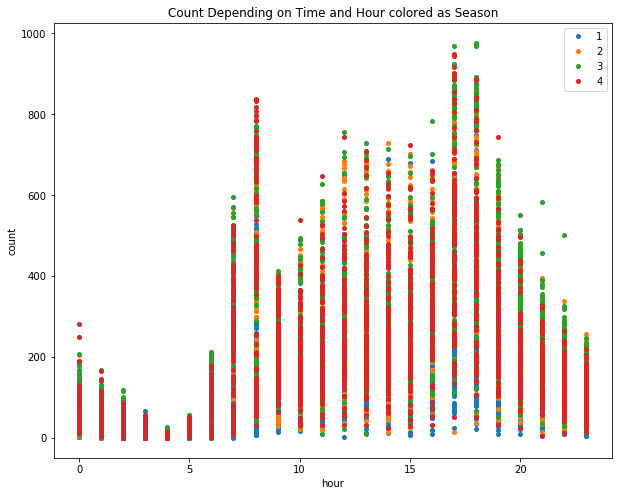

In [17]:
# scatter = plt.scatter(data_train['hour'], data_train['count'], c=data_train['season'], cmap='Greens', s=10)
# plt.legend(handles=scatter.legend_elements()[0], title="Season")
plt.figure(figsize=(10, 8))
groups = data_train.groupby('season')
for name, group in groups:
    plt.plot(group['hour'].values, group['count'].values, marker='o', linestyle='', markersize=4, label=name)
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Count Depending on Time and Hour colored as Season')
plt.legend()

The relationship between count and hour changes by season. 

#### e. Does the distribution of hourly number of rentals change between 2011 and 2012? What does this tell you about the rental business?

Text(0.5, 1.0, 'Hourly Number of Rentals in 2012')

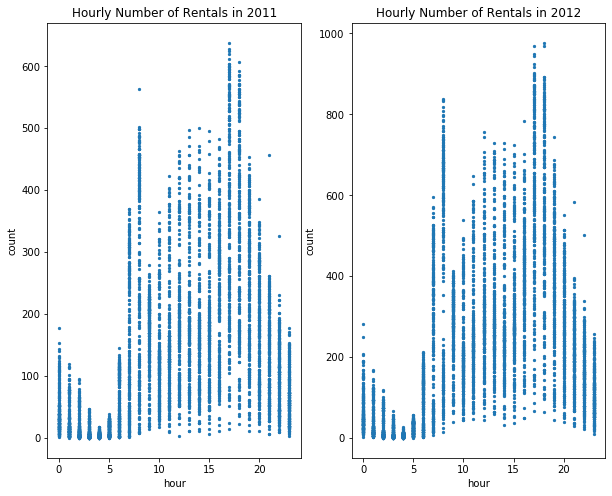

In [18]:
year_2011 = data_train[data_train['year'] == 2011]
year_2012 = data_train[data_train['year'] == 2012]
plt.figure(figsize=(10, 8))
plt.subplot(1, 2, 1)
plt.scatter(year_2011['hour'], year_2011['count'], s=5)
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Hourly Number of Rentals in 2011')
plt.subplot(1, 2, 2)
plt.scatter(year_2012['hour'], year_2012['count'], s=5)
plt.xlabel('hour')
plt.ylabel('count')
plt.title('Hourly Number of Rentals in 2012')

The distribution of hourly number of rentals does not change greatly between 2011 and 2012.

For rental business, the business mode in 2012 can follow that in 2011.

### 2. Random Forest and Boosting
#### a. Create a partial dependence plot for predicted count vs each one of the following variables: windspeed, humidity, temp, and atemp. 

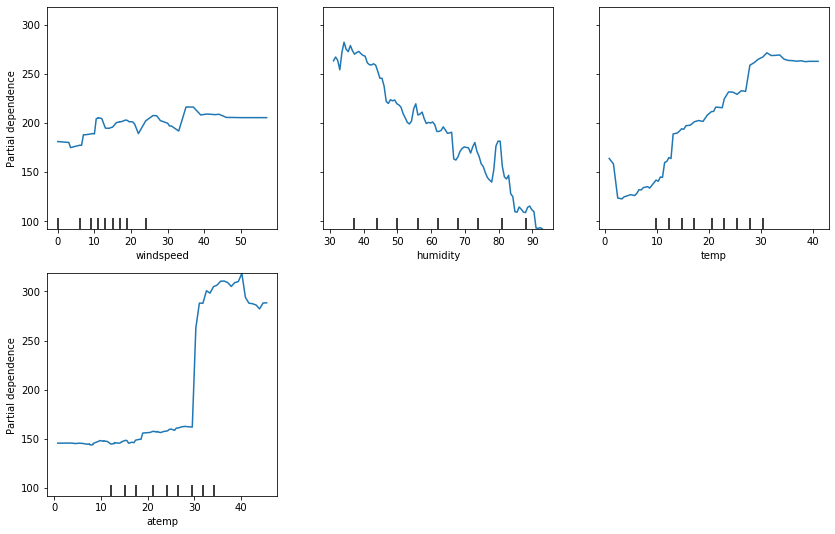

In [19]:
train_features = data_train[['windspeed', 'humidity', 'temp', 'atemp']]
train_count = data_train['count']
feature = ['windspeed', 'humidity', 'temp', 'atemp']
reg_RF = RandomForestRegressor(random_state=42)
reg_RF.fit(train_features, train_count)
plot_partial_dependence(reg_RF, train_features, features=feature)
fig = plt.gcf()
fig.set_size_inches(14, 9)

# default_importance = regr.feature_importances_
# from sklearn.inspection import permutation_importance
# perm_importance = permutation_importance(regr, X_train, Y_train)

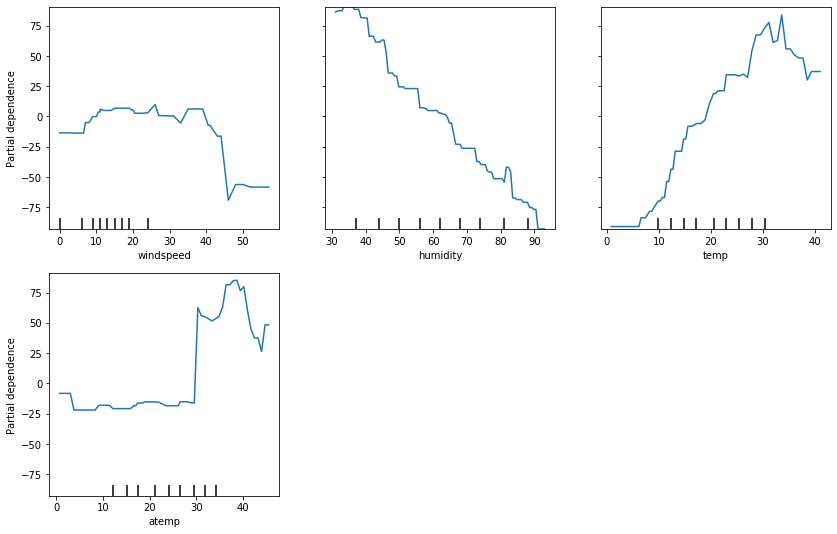

In [20]:
boosting = GradientBoostingRegressor()
boosting.fit(train_features, train_count)
plot_partial_dependence(boosting, train_features, features=feature)
fig = plt.gcf()
fig.set_size_inches(14, 9)

#### b. Build a marginal model that regresses count on each one of the following variables separately: windspeed, humidity, temp, and atemp.

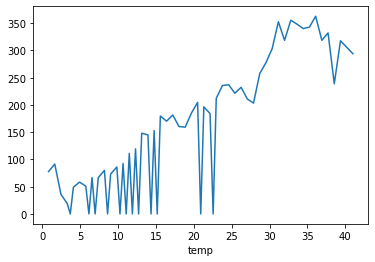

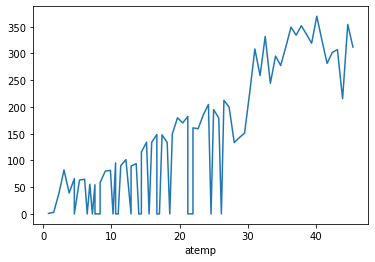

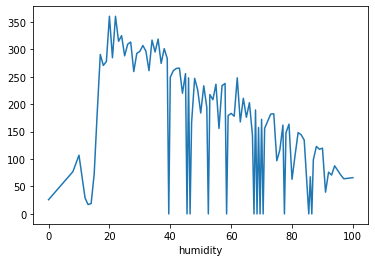

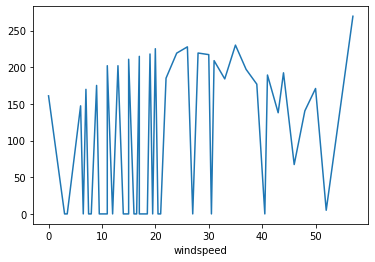

In [21]:
# rt_windspeed = data_train['windspeed']
# rt_humidity = data_train['humidity']
# rt_temp = data_train['temp']
# rt_atemp = data_train['atemp']
features = ['temp', 'atemp', 'humidity', 'windspeed']
def rt(feature):
    data_train.sort_values(by=[feature], inplace=True)
    rt_model = DecisionTreeRegressor()
    rt_model.fit(data_train[feature].values.reshape((-1, 1)), data_train['count'].values.reshape((-1, 1)))
    pred = rt_model.predict(data_train[feature].values.reshape((-1, 1)))
    plt.figure()
    plt.plot(data_train[feature].values.reshape((-1, 1)), pred)
    plt.xlabel(feature)
    plt.show()
for i in features:
    rt(i)

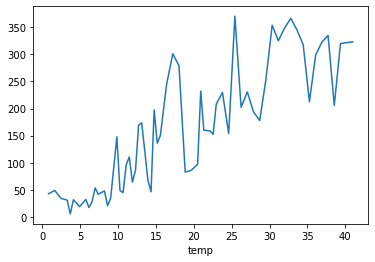

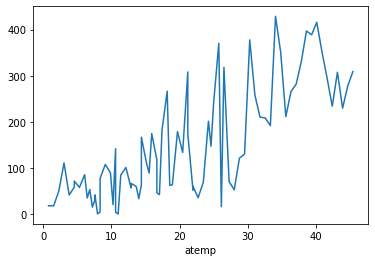

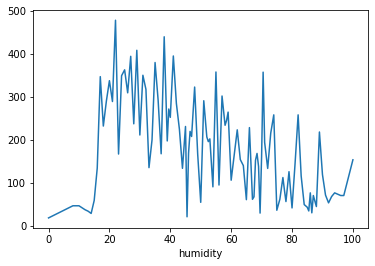

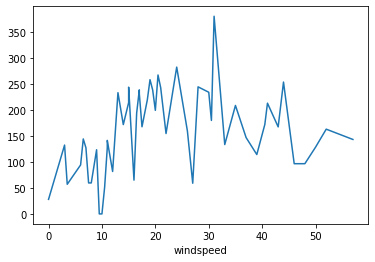

In [22]:
def knn(feature):
    data_train.sort_values(by=[feature], inplace=True)
    knn_model = KNeighborsRegressor()
    knn_model.fit(data_train[feature].values.reshape((-1, 1)), data_train['count'].values.reshape((-1, 1)))
    pred = knn_model.predict(data_train[feature].values.reshape((-1, 1)))
    plt.figure()
    plt.plot(data_train[feature].values.reshape((-1, 1)), pred)
    plt.xlabel(feature)
    plt.show()
for i in features:
    knn(i)

#### c. Create variable importance plots for Random Forest and Boosting. Do the two models rank the variables in the same way?

Text(0.5, 1.0, 'Boosting')

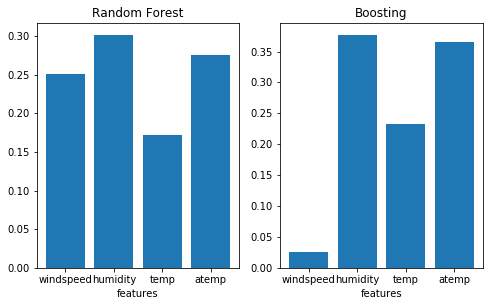

In [23]:
# perm_importance_rf = permutation_importance(reg_RF, train_features, train_count)
# importance_mean_rf = perm_importance_rf.importances_mean
# perm_importance_bst = permutation_importance(boosting, train_features, train_count)
# importance_mean_bst = perm_importance_bst.importances_mean

RF_importance = reg_RF.feature_importances_
bst_importance = boosting.feature_importances_

plt.figure(figsize=(8, 4.5))
plt.subplot(1, 2, 1)
plt.bar(['windspeed', 'humidity', 'temp', 'atemp'], RF_importance)
plt.xlabel('features')
plt.title('Random Forest')
plt.subplot(1, 2, 2)
plt.bar(['windspeed', 'humidity', 'temp', 'atemp'], bst_importance)
plt.xlabel('features')
plt.title('Boosting')

Two models don't rank the variables in the same way. Both models rank humidity and atemp as two of the most important features, while for Random Forest, windspeed ranks third and temp ranks fourth and for Boosting the situation is vice versa.

Since Random Forest randomly selects m(<=p) features for each tree, individual features can have higher importance. However, the most powerful features are always dominant in the boosting model. This result makes sense. 

### 3.
#### a & c. What can you say by comparing how predictive each variable is on its own vs the variable importance ranking obtained in the previous question?

Text(0, 0.5, 'MSE')

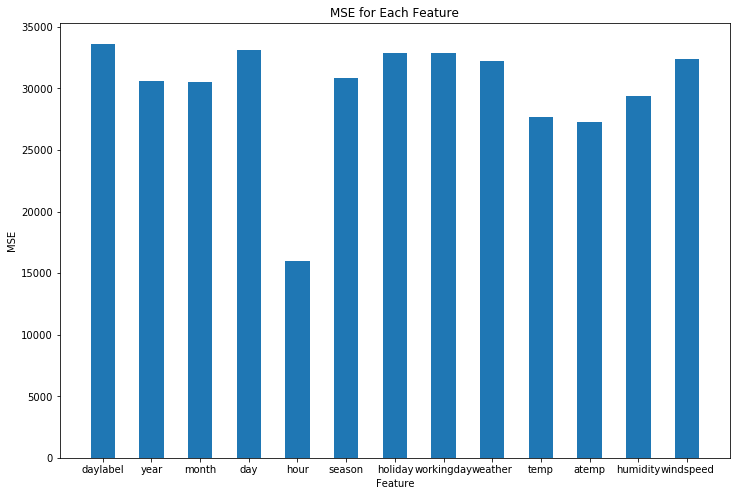

In [24]:
features = ['daylabel', 'year', 'month', 'day', 'hour', 'season', 
            'holiday', 'workingday', 'weather', 'temp', 'atemp', 'humidity', 'windspeed']
def rt_model(feature):
    X_train, X_test, y_train, y_test = train_test_split(data_train[feature].values.reshape((-1, 1)), 
                                                        data_train['count'].values.reshape((-1, 1)), 
                                                        test_size=0.75, random_state=1)
    regression_tree_model = DecisionTreeRegressor()
    regression_tree_model.fit(X_train, y_train)
    y_pred = regression_tree_model.predict(X_test)
    error = mean_squared_error(y_test, y_pred)
    return error
MSEs = []    
for i in features:
    MSEs.append(rt_model(i))

plt.figure(figsize=(12, 8))
plt.bar(features, MSEs, width=0.5)
plt.title('MSE for Each Feature')
plt.xlabel('Feature')
plt.ylabel('MSE')

### 4. Do some data exploration and data cleaning before we train our final model

In [10]:
# del humidity = 0
bike_train = data_train.loc[data_train['humidity'] != 0, :]

In [11]:
# add day of week column
def get_weekday(row):
    """
    Adds a new column of the day of week from the datetime column.

    :param df: dataframe
    :return: dataframe
    """
    date_str = "{}-{}-{}".format(row["year"].astype(int), row["month"].astype(int), row["day"].astype(int))
    date = datetime.strptime(date_str, '%Y-%m-%d')
    return date.isoweekday()


bike_train["weekday"] = bike_train.apply(get_weekday, axis=1)

<ipython-input-11-a1fed91350b0>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bike_train["weekday"] = bike_train.apply(get_weekday, axis=1)


In [12]:
# Bike train weather data has values with decimals ending in ".5", which doesn't make sense
bike_train[bike_train['weather'].astype(str).str.contains('.5')]
bike_train = bike_train[~bike_train['weather'].astype(str).str.contains('.5')]

In [13]:
# split the data
y_train = bike_train['count']
X_train = bike_train.drop(['count'], axis=1)

Below we are doing a bunch of different things.

1. Drop day column. After adding the day of the week {1,2,3,4,5,6,7} for {Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday}, the day column is not useful anymore.

2. Make dummies for year, month, "weekday", season, holiday, workingday, weather. Here we are not dropping the first class for each dummy. (We know for linear regression that if we have for example a dummy for gender = male or female, we will only get 1 dummy variable where 1=female and 0=male, leaving k-1 classes for each dummy . In this case, for our dummies, we are actually leaving k classes)

3. Scale the variables that are not dummy with RobustScaler, this is similar to normalizing the data, but performs better when there are outliers

4. Create interactions for all the variables (2 degree polynomial features). We went from 39 columns of features to 780 columns

In [14]:
# drop day column
X_train = X_train.drop(['day'], axis=1)

# dummies
X_train_dummies = pd.get_dummies(X_train, columns=["year", "month", "weekday", "season", "holiday", "workingday", "weather"])

# scaling
scaler = RobustScaler()
scaler.fit(X_train_dummies.loc[:, ["temp", "atemp", "humidity", "windspeed"]])

X_train_dummies.loc[:, ["temp", "atemp", "humidity", "windspeed"]] = scaler.transform(
    X_train_dummies.loc[:, ["temp", "atemp", "humidity", "windspeed"]])

# interactions
poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
X_train_dummies_poly = poly.fit_transform(X_train_dummies)

In [16]:
# split data into train and val set
X_train, X_val, y_train, y_val = train_test_split(X_train_dummies_poly, y_train, test_size=0.2, random_state=1706)

y_train_log = np.log(y_train + 1)
y_val_log = np.log(y_val + 1)

It's important to convert target variable (y) into log(y + 1).

### 5. Build a model to predict the bikeshare counts for the hours recorded in the test dataset.

In [27]:
params = {
    'max_depth': [8],
    'learning_rate': [0.05, 0.07],
    'colsample_bytree': [0.3],
    'n_estimators': [300, 500],
    'gamma': [0.1],
}

xgbr = xgb.XGBRegressor(seed=42)
clf = GridSearchCV(estimator=xgbr, param_grid=params, scoring='neg_mean_squared_error', cv=5, verbose=5, n_jobs=-1)


clf.fit(X_train, y_train_log)

In [28]:
# saving to not lose on restart of kernel
# obtained doing clf.best_params_
best_params = {'colsample_bytree': 0.3,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 8,
 'n_estimators': 500}

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10932 entries, 3992 to 2226
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   daylabel    10932 non-null  int64   
 1   year        10932 non-null  int64   
 2   month       10932 non-null  int64   
 3   day         10932 non-null  int64   
 4   hour        10932 non-null  int64   
 5   season      10932 non-null  category
 6   holiday     10932 non-null  category
 7   workingday  10932 non-null  category
 8   weather     10932 non-null  category
 9   temp        10932 non-null  float64 
 10  atemp       10932 non-null  float64 
 11  humidity    10932 non-null  float64 
 12  windspeed   10932 non-null  float64 
 13  count       10932 non-null  int64   
dtypes: category(4), float64(4), int64(6)
memory usage: 982.8 KB


In [55]:
xgb2 = xgb.XGBRegressor(seed=42, **best_params)
xgb2.fit(X_train, y_train_log)

{'max_depth': 50, 'n_estimators': 650, 'random_state': 42}

In [53]:
pd.DataFrame(xgb2.feature_importances_, 
             index=poly.get_feature_names_out(X_train_dummies.columns)).sort_values(by=0, ascending=False)

,0
1,13.030769
2,6.167692
3,5.096923
4,3.045538
5,2.596923
...,...
6489,297.866154
6490,202.233846
6491,148.646154
6492,115.406154


In [54]:
np.expm1(xgb2.predict(X_val)).round(0)

# RMSE
np.sqrt(np.mean(np.square(np.expm1(xgb2.predict(X_val)).round(0) - y_val)))

In [ ]:
np.mean(np.square(xgb2.predict(X_val) - y_val_log))

Transform test data set.

In [ ]:
bike_test["weekday"] = bike_test.apply(get_weekday, axis=1)

## drop day column
X_test = bike_test.drop(['day'], axis=1)

## dummies
X_test_dummies = pd.get_dummies(X_test, columns=["year", "month", "weekday", "season", "holiday", "workingday", "weather"])


X_test_dummies.loc[:, ["temp", "atemp", "humidity", "windspeed"]] = scaler.transform(
    X_test_dummies.loc[:, ["temp", "atemp", "humidity", "windspeed"]]
)

X_test_dummies.rename(columns={'weather_1': 'weather_1.0', 'weather_2': "weather_2.0", 'weather_3': "weather_3.0", 'weather_4': "weather_4.0"}, inplace=True)

## interactions
X_test_dummies_poly = poly.transform(X_test_dummies)

In [ ]:
y_pred = xgb2.predict(X_test_dummies_poly)
y_pred_expm1 = np.expm1(y_pred).round(0).astype(int)

pd.DataFrame([list(range(1, y_pred_expm1.shape[0]+1)), 
              y_pred_expm1], index=['Id', 'count']).T.to_csv('submission9.csv', index=False)